In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
print("Доступные устройства:", tf.config.list_physical_devices())
print("TensorFlow использует GPU:", tf.test.is_gpu_available())
print("Имя устройства GPU:", tf.test.gpu_device_name())
print("Доступные устройства:", tf.config.list_physical_devices('GPU'))
print(tf.__version__)


Доступные устройства: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow использует GPU: True
Имя устройства GPU: /device:GPU:0
Доступные устройства: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2.18.0


I0000 00:00:1748880149.853477      35 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748880149.853718      35 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1748880149.855734      35 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748880149.855951      35 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_100_slice_0.h5
['image', 'mask']
(240, 240, 4) (240, 240, 3)


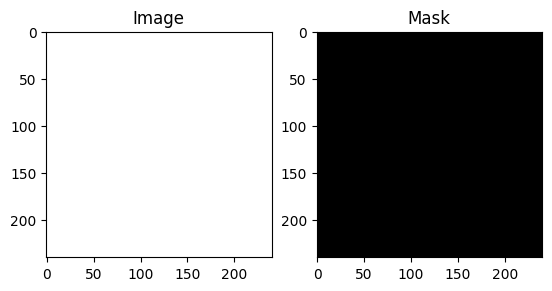

In [23]:
data_dir = '/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data'
files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.h5')])
print(files[0])

with h5py.File(files[0], 'r') as f:
    print(list(f.keys()))  #смотрим какие ключи!
    img = f['image'][:]
    mask = f['mask'][:]
    print(img.shape, mask.shape)
    plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Image')
    plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title('Mask')
    plt.show()

Подготовка датасета

In [24]:
IMG_SIZE = 64

def preprocess(img, mask):
    # img: (240, 240, 4), mask: (240, 240, 3)
    img = img[..., 0]  
    mask = mask[..., 0]
    # Resize до (64, 64, 1)
    img = tf.image.resize(img[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy()  # (64, 64, 1)
    mask = tf.image.resize(mask[..., np.newaxis], (IMG_SIZE, IMG_SIZE), method='nearest').numpy()  # (64, 64, 1)
    # Нормализация
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    mask = (mask > 0).astype(np.float32)
    return img, mask

X, y = [], []
for file in tqdm(files[:600]):  # для теста возьми 500 файлов, потом увеличь
    with h5py.File(file, 'r') as f:
        img = f['image'][:]
        mask = f['mask'][:]
    img, mask = preprocess(img, mask)
    X.append(img)
    y.append(mask)

# Преобразуем в numpy массивы и добавляем канал 
X = np.array(X)[..., np.newaxis]  
y = np.array(y)[..., np.newaxis]  

# Проверка формы данных
print("Форма X:", X.shape)
print("Форма y:", y.shape) 

# Найди индексы с опухолью и без
tumor_idx = np.where([mask.sum() > 0 for mask in y])[0]
no_tumor_idx = np.where([mask.sum() == 0 for mask in y])[0]

n_tumor = len(tumor_idx)
n_no_tumor = len(no_tumor_idx)
n_repeat = n_no_tumor // n_tumor

# Oversample tumor slices
X_tumor = np.repeat(X[tumor_idx], n_repeat, axis=0)
y_tumor = np.repeat(y[tumor_idx], n_repeat, axis=0)

X_balanced = np.concatenate([X[no_tumor_idx], X_tumor], axis=0)
y_balanced = np.concatenate([y[no_tumor_idx], y_tumor], axis=0)

perm = np.random.permutation(len(X_balanced))
X_balanced = X_balanced[perm]
y_balanced = y_balanced[perm]

# стратификационная метка: 1 — есть опухоль, 0 — нет
stratify_labels = [mask.sum() > 0 for mask in y_balanced]

X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=stratify_labels
)

# Проверка формы данных после разделения
print("Форма X_train:", X_train.shape)
print("Форма y_train:", y_train.shape)
print("Форма X_val:", X_val.shape)
print("Форма y_val:", y_val.shape)

  0%|          | 0/600 [00:00<?, ?it/s]

Форма X: (600, 64, 64, 1, 1)
Форма y: (600, 64, 64, 1, 1)
Форма X_train: (702, 64, 64, 1, 1)
Форма y_train: (702, 64, 64, 1, 1)
Форма X_val: (176, 64, 64, 1, 1)
Форма y_val: (176, 64, 64, 1, 1)


Баланс до разбиения: Counter({False: 461, True: 417})
Баланс в train: Counter({False: 369, True: 333})
Баланс в val: Counter({False: 92, True: 84})


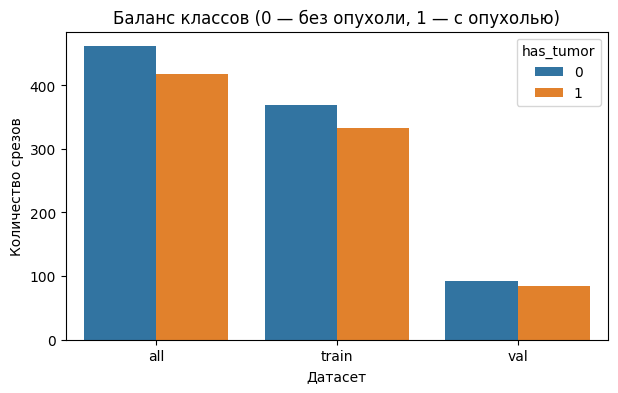

In [25]:
from collections import Counter

# Считаем наличие опухоли в y_balanced
if y_balanced.ndim == 4 and y_balanced.shape[-1] == 1:
    y_flat = y_balanced.squeeze(-1)
else:
    y_flat = y_balanced
has_tumor = np.array([mask.sum() > 0 for mask in y_flat])

print('Баланс до разбиения:', Counter(has_tumor))

# Стратифицированный split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, strat_train, strat_val = train_test_split(
    X_balanced, y_balanced, has_tumor, test_size=0.2, random_state=42, stratify=has_tumor
)

# Баланс после разбиения
print('Баланс в train:', Counter(strat_train))
print('Баланс в val:', Counter(strat_val))

counts = {
    'all': Counter(has_tumor),
    'train': Counter(strat_train),
    'val': Counter(strat_val)
}
df = (
    pd.DataFrame([
        {'split': split, 'has_tumor': int(k), 'count': v}
        for split, c in counts.items()
        for k, v in c.items()
    ])
)
plt.figure(figsize=(7,4))
sns.barplot(data=df, x='split', y='count', hue='has_tumor')
plt.title('Баланс классов (0 — без опухоли, 1 — с опухолью)')
plt.ylabel('Количество срезов')
plt.xlabel('Датасет')
plt.show()

Архитектура U-Net

In [26]:
def unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = keras.Input(shape=input_shape)
    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)
    # Bottleneck
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    # Decoder
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)
    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)
    return keras.Model(inputs, outputs)

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 16)     │            160 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 64, 64, 16)     │          2,320 │ conv2d_60[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 32, 32, 16)     │              0 │ conv2d_61[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 32, 32, 32)     │          4,640 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 16, 16, 32)     │              0 │ conv2d_63[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ conv2d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 8, 8, 64)       │              0 │ conv2d_65[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 8, 8, 128)      │        147,584 │ conv2d_66[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_12          │ (None, 16, 16, 128)    │              0 │ conv2d_67[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 16, 16, 192)    │              0 │ up_sampling2d_12[0][0… │
│ (Concatenate)             │                        │                │ conv2d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 16, 16, 64)     │        110,656 │ concatenate_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ conv2d_68[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_13     

 Total params: 487,009 (1.86 MB)

 Trainable params: 487,009 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Обучение

In [27]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Модель
model = unet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coef]
)

# Колбэки
callbacks = [
    keras.callbacks.ModelCheckpoint('unet_brats.h5', save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

# Обучение
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9259 - dice_coef: 0.0057 - loss: 0.2327 - val_accuracy: 0.9959 - val_dice_coef: 0.0253 - val_loss: 0.0188
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9955 - dice_coef: 0.0475 - loss: 0.0191 - val_accuracy: 0.9959 - val_dice_coef: 0.1022 - val_loss: 0.0126
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9957 - dice_coef: 0.1697 - loss: 0.0126 - val_accuracy: 0.9959 - val_dice_coef: 0.3264 - val_loss: 0.0070
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9954 - dice_coef: 0.3957 - loss: 0.0071 - val_accuracy: 0.9959 - val_dice_coef: 0.4061 - val_loss: 0.0058
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9962 - dice_coef: 0.4333 - loss: 0.0058 - val_accuracy: 0.9960 - val_dice_coef: 0.2428 - val_loss: 0.0114
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9968 - dice_coef: 0.4391 - loss: 0.0077 - val_accuracy: 0.9982 - val_dice_coef: 0.5

Визуализация результатов

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


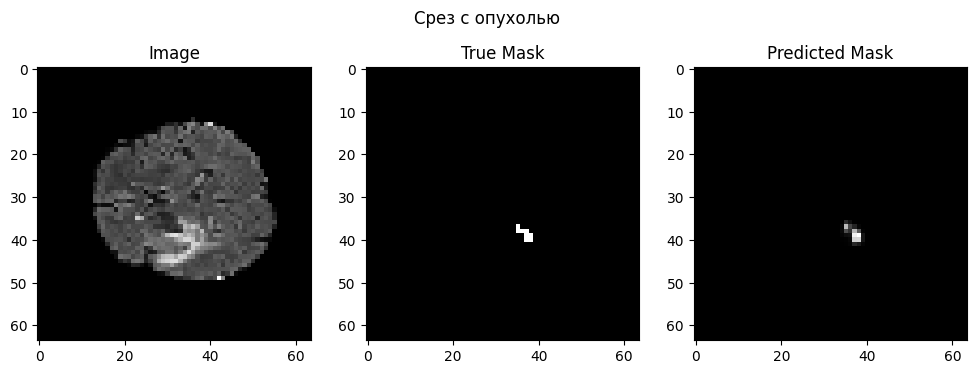

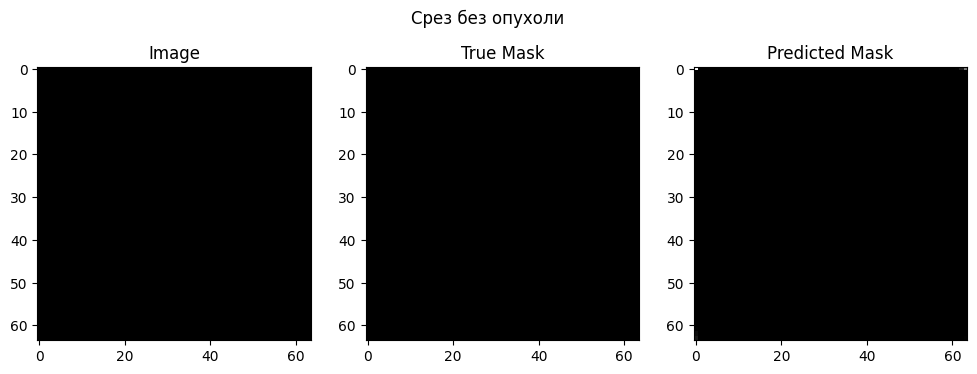

In [28]:
def plot_sample(X, y_true, y_pred, idx, title=""):
    plt.figure(figsize=(12,4))
    plt.suptitle(title)
    plt.subplot(1,3,1); plt.imshow(X[idx].squeeze(), cmap='gray'); plt.title('Image')
    plt.subplot(1,3,2); plt.imshow(y_true[idx].squeeze(), cmap='gray'); plt.title('True Mask')
    plt.subplot(1,3,3); plt.imshow(y_pred[idx].squeeze(), cmap='gray'); plt.title('Predicted Mask')
    plt.show()

y_pred = model.predict(X_val)

# Индекс среза с опухолью
tumor_indices = np.where(y_val.sum(axis=(1,2,3)) > 0)[0]
if len(tumor_indices) > 0:
    plot_sample(X_val, y_val, y_pred, tumor_indices[0], title="Срез с опухолью")
else:
    print("Нет срезов с опухолью в валидации!")

# Индекс среза без опухоли
no_tumor_indices = np.where(y_val.sum(axis=(1,2,3)) == 0)[0]
if len(no_tumor_indices) > 0:
    plot_sample(X_val, y_val, y_pred, no_tumor_indices[0], title="Срез без опухоли")
else:
    print("Нет срезов без опухоли в валидации!")